In [1]:
import os

path_1 = './data/TL_다국어-한국어_deko_기타'
path_2 = './data/TL_다국어-한국어_deko_다큐교양'
path_3 = './data/TL_다국어-한국어_deko_영화드라마'

file_1_list = os.listdir(path_1)
file_2_list = os.listdir(path_2)
file_3_list = os.listdir(path_3)

# 전체 파일 경로 리스트 생성
file_1_paths = [os.path.join(path_1, file) for file in file_1_list]
file_2_paths = [os.path.join(path_2, file) for file in file_2_list]
file_3_paths = [os.path.join(path_3, file) for file in file_3_list]

file_paths = file_1_paths + file_2_paths + file_3_paths

In [2]:
import json

parsered_data = [] # 파싱 데이터를 저장할 변수

for file_path in file_paths:
    #json파일 불러오기
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

        # 문서 정보 중 필요항목을 딕셔너리에 담고 리스트에 추가
        raw_dict = {
            "문서ID" : data['ID'],
            "번역" : "독->한",
            "원문(src)" : data['원문'],
            "번역문(tar)" : data['최종번역문']
        }
        parsered_data.append(raw_dict)

In [3]:
import pandas as pd

# 파싱이 완료된 데이터를 Dataframe 형식으로 변환
raw_data = pd.DataFrame(parsered_data)

In [4]:
# 데이터 및 텍스트 전처리 함수를 모듈화 시킨 파일
from NLP_pp import *

In [5]:
# 데이터셋읜 결측치 & 중복치 제거 함수 실행
raw_data = df_cleaning(raw_data, '원문(src)')
raw_data = df_cleaning(raw_data, '번역문(tar)')

In [6]:
import re

def regex_sub_DE(sent):
    # 입력 텍스트를 소문자로 변환
    sent = sent.lower()
    # 단어와 구두점 사이에 공백을 추가
    sent = re.sub(r"([?.!,¿])", r" \1", sent)
    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    return sent.strip()

def regex_sub_KR(sent):
    # 단어와 구두점 사이에 공백을 추가
    sent = re.sub(r"([?.!,¿])", r" \1", sent)
    # 단순하게 텍스트에서 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    return sent.strip()

In [7]:
# 독일어, 한국어에 대한 데이터 클리닝 수행
raw_data['원문(src)'] = raw_data['원문(src)'].apply(regex_sub_DE)
raw_data['번역문(tar)'] = raw_data['번역문(tar)'].apply(regex_sub_KR)

In [8]:
display(raw_data)

,문서ID,번역,원문(src),번역문(tar)
0,ot_100615,독->한,"mal sehen , ob meine haut reagiert oder nicht .",내 피부가 반응하는지 보자 .
1,ot_100616,독->한,ich habe viele großartige kritiken über drunk ...,저는 드렁크 엘리펀트에 대한 훌륭한 리뷰를 많이 들었습니다 .
2,ot_100617,독->한,lass uns zur poolparty gehen .,수영장 파티에 가자 .
3,ot_100618,독->한,sie bringen einen neuen reiniger auf den markt .,그들은 새로운 청소기를 시장에서 출시하고 있어요 .
4,ot_100619,독->한,genau hier ist nur gepresster gemüsesaft .,바로 여기에 압착 야채 주스가 있어요 .
...,...,...,...,...
120327,md_100608,독->한,"er sucht nach dem ort , der die bewohner verei...","그는 주민들을 결집시킬 수 있는 장소를 찾아다녔고 , 이를 빵집에서 찾는다 ."
120328,md_100609,독->한,"coelho costinha ist ein einfacher mann , der j...",코엘호 코스틴하는 재정적인 어려움을 겪고 있는 평범한 사람이다 .
120329,md_100610,독->한,"als sie aufwacht , ist sie doppelt so alt , de...","그녀가 깨어났을 때 , 그녀는 나이가 두 배나 많이 들었지만 , 여전히 10대처럼 ..."
120330,md_100611,독->한,"viele frauen stecken in der misere , und alle ...","많은 여성들이 불행 속에 살고 있고 , 그들 모두는 그들의 상황에서 벗어날 길을 찾..."


In [9]:
raw_data.to_csv('exam_deko.csv', index=False)

In [10]:
# 인코더의 입력 데이터인 src 데이터
raw_src_data = raw_data['원문(src)'].values.tolist()
# 디코더의 정답지 데이터인 tar 데이터
raw_tar_data = raw_data['번역문(tar)'].values.tolist()

In [11]:
from transformers import BertTokenizer

# 독일어 토크나이저 모델: dbmdz/bert-base-german-uncased
german_tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-german-uncased")
# 한국어 토크나이저 모델: kykim/bert-kor-base
korean_tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base")

In [12]:
# 원문 토큰화 수행
tokenized_src_data = tokenize(raw_src_data, german_tokenizer, arch='Bert')
# 번역문 토큰화 수행
tokenized_tar_data = tokenize(raw_tar_data, korean_tokenizer, arch='Bert')

토큰화 진행 중: 100%|██████████| 120332/120332 [00:14<00:00, 8544.88it/s]


In [13]:
from sklearn.model_selection import train_test_split

# 훈련/검증/평가를 80%, 15%, 5%로 분할을 수행
# random_state -> 데이터셋을 내누는데 '재현성' 유지를 위해 넣음 -> 안넣어도 됨
# stratify -> y 클래스 비율을 알기 어렵기에 해당 항목은 없앰
src_train, src_etc, tar_train, tar_etc = train_test_split(
    tokenized_src_data, tokenized_tar_data, test_size=0.20,
    random_state=42
)

# 그 외 데이터셋을 반반으로 Val, Test로 나눔
src_val, src_test, tar_val, tar_test = train_test_split(
    src_etc, tar_etc, test_size=0.25,
    random_state=42
)

In [14]:
from collections import Counter

src_word_list = []
tar_word_list = []
# train항목을 워드 리스트에 입력
for src_sent, tar_sent in zip(src_train, tar_train):
    for word in src_sent:
        src_word_list.append(word)
    for word in tar_sent:
        tar_word_list.append(word)
# val항목을 워드 리스트에 입력
for src_sent, tar_sent in zip(src_train, tar_train):
    for word in src_sent:
        src_word_list.append(word)
    for word in tar_sent:
        tar_word_list.append(word)

# 단어와 해당 단어의 출몰 빈도를 함께 저장하는
# Counter 타입의 변수 생성
src_word_counts = Counter(src_word_list)
tar_word_counts = Counter(tar_word_list)

In [15]:
rare_th = 0 #희소단어의 등장 빈도를 결정하는 파라미터
# 희소단어 등장 빈도를 바탕으로 희소 단어를 배제하기 위해 준비 함수
print(f'---원문(src)에 대한 희소단어 분석---')
src_tot_vocab_cnt, src_rare_vocab_cnt = set_rare_vocab(src_word_counts, rare_th, report=True)
print(f'\n---번역문(tar)에 대한 희소단어 분석---')
tar_tot_vocab_cnt, tar_rare_vocab_cnt = set_rare_vocab(tar_word_counts, rare_th, report=True)

---원문(src)에 대한 희소단어 분석---
초기 단어장에 기록된 단어 종류 : 22471
초기 단어장 중 희소단어(-1번 미만 등장) 종류 : 0
초기 단어장 내 희소단어 비율 : 0.00 %
전체 단어 중 희소단어 등장 비율 : 0.00 %

---번역문(tar)에 대한 희소단어 분석---
초기 단어장에 기록된 단어 종류 : 25697
초기 단어장 중 희소단어(-1번 미만 등장) 종류 : 0
초기 단어장 내 희소단어 비율 : 0.00 %
전체 단어 중 희소단어 등장 비율 : 0.00 %


In [16]:
#등장 빈도가 높은 단어 순으로 정렬하기
src_vocab = sorted(src_word_counts, key=src_word_counts.get, reverse=True)
tar_vocab = sorted(tar_word_counts, key=tar_word_counts.get, reverse=True)

# 원문(src)에 대한 희소단어 배제 & 정렬 작업 수행
src_vocab_size = src_tot_vocab_cnt - src_rare_vocab_cnt
src_vocab = src_vocab[:src_vocab_size]
# 번역문(tar에 대한 희소단어 배제 & 정렬 작업 수행
tar_vocab_size = tar_tot_vocab_cnt - tar_rare_vocab_cnt
tar_vocab = tar_vocab[:tar_vocab_size]

In [17]:
# 스페셜 토큰 선언
spec_token = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']
# 스페셜 토큰을 포함한 {단어:단어idx}의 딕셔너리 생성
print(f'---원문(src)에 대한 단어장 분석---')
src_to_idx, idx_to_src = set_word_to_idx(spec_token, src_vocab, 
                                         report=True)
print(f'\n---번역문(tar)에 대한 단어장 분석---')
tar_to_idx, idx_to_tar = set_word_to_idx(spec_token, tar_vocab, 
                                         report=True)

---원문(src)에 대한 단어장 분석---
단어집합(vocab)은 word_to_idx를 통해서
[단어 : idx]의 <class 'dict'>타입이 되고
스페셜 토큰 <PAD> <UNK> <SOS> <EOS> 을 포함하여
총 관리되는 단어 '22471' -> '22475'가 됨

---번역문(tar)에 대한 단어장 분석---
단어집합(vocab)은 word_to_idx를 통해서
[단어 : idx]의 <class 'dict'>타입이 되고
스페셜 토큰 <PAD> <UNK> <SOS> <EOS> 을 포함하여
총 관리되는 단어 '25697' -> '25701'가 됨


In [18]:
# 원문(src) 데이터셋의 정수 인코딩 수행
e_src_train = text_to_sequences(src_train, src_to_idx)
e_src_val = text_to_sequences(src_val, src_to_idx)
e_src_test = text_to_sequences(src_test, src_to_idx)

# 번역문(tar) 데이터셋의 정수 인코딩 수행
e_tar_train = text_to_sequences(tar_train, tar_to_idx)
e_tar_val = text_to_sequences(tar_val, tar_to_idx)
e_tar_test = text_to_sequences(tar_test, tar_to_idx)

In [19]:
# 번역문(tar)의 접두/접미에 SOS, EOS 토큰 추가
e_tar_train = prefix_suffix_token_insert(e_tar_train, spec_token)
e_tar_val = prefix_suffix_token_insert(e_tar_val, spec_token)
e_tar_test = prefix_suffix_token_insert(e_tar_test, spec_token)

훈련 데이터셋 최대 길이: 57
훈련 데이터셋 평균 길이: 16.71


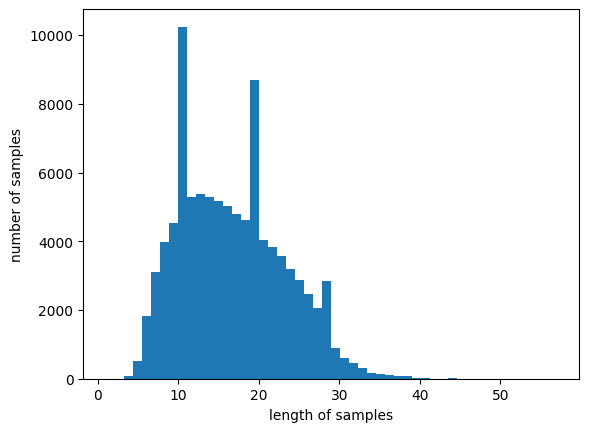

데이터셋 문장 길이가 60 이하 데이터 비율: 100.00%


In [20]:
# 원문(src)에 대한 문장패딩 하이퍼 파라미터 설정
src_seq_len = 60
set_sent_pad(e_src_train, src_seq_len, report=True)

훈련 데이터셋 최대 길이: 55
훈련 데이터셋 평균 길이: 15.82


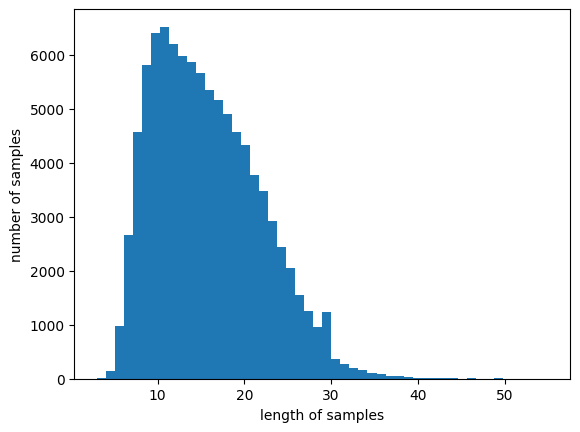

데이터셋 문장 길이가 55 이하 데이터 비율: 100.00%


In [21]:
# 번역문(tar)에 대한 문장패딩 하이퍼 파라미터 설정
tar_seq_len = 55
set_sent_pad(e_tar_train, tar_seq_len, report=True)

In [22]:
# 원문(src)의 문장 패딩(정수인코딩 완료)
padded_src_train = pad_seq_x(e_src_train, src_seq_len)
padded_src_val = pad_seq_x(e_src_val, src_seq_len)
padded_src_test = pad_seq_x(e_src_test, src_seq_len)

# 번역문(tar)의 문장 패딩(정수인코딩 완료)
padded_tar_train = pad_seq_x(e_tar_train, tar_seq_len)
padded_tar_val = pad_seq_x(e_tar_val, tar_seq_len)
padded_tar_test = pad_seq_x(e_tar_test, tar_seq_len)

In [23]:
print(f'---원문(src) 문장 패딩 결과---')
val_pad_shape(padded_src_train, '훈련')
val_pad_shape(padded_src_val, '검증')
val_pad_shape(padded_src_test, '평가')
print(f'\n---번역문(tar) 문장 패딩 결과---')
val_pad_shape(padded_tar_train, '훈련')
val_pad_shape(padded_tar_val, '검증')
val_pad_shape(padded_tar_test, '평가')

---원문(src) 문장 패딩 결과---
훈련용 정수(원핫)인코딩 shape: (96265, 60)
검증용 정수(원핫)인코딩 shape: (18050, 60)
평가용 정수(원핫)인코딩 shape: (6017, 60)

---번역문(tar) 문장 패딩 결과---
훈련용 정수(원핫)인코딩 shape: (96265, 55)
검증용 정수(원핫)인코딩 shape: (18050, 55)
평가용 정수(원핫)인코딩 shape: (6017, 55)


In [24]:
import torch
bs = 256 # Batch_size 하이퍼 파라미터

# 정수(원핫)인코딩 데이터를 데이터로더로 변환
trainloader = set_dataloader(padded_src_train, padded_tar_train, bs, 
                             content='훈련', report=True)
valloader = set_dataloader(padded_src_val, padded_tar_val, bs,
                           content='검증', report=True)
testloader = set_dataloader(padded_src_test, padded_tar_test, bs, 
                            content='평가', report=True)

훈련용 X(인코딩)데이터 크기: [96265, 60]
훈련용 Y(Label)데이터 크기: [96265, 55]
검증용 X(인코딩)데이터 크기: [18050, 60]
검증용 Y(Label)데이터 크기: [18050, 55]
평가용 X(인코딩)데이터 크기: [6017, 60]
평가용 Y(Label)데이터 크기: [6017, 55]


In [25]:
# 주요 하이퍼 파라미터 정리
src_VS = len(src_to_idx) # 원문 단어장 개수
tar_VS = len(tar_to_idx) # 번역문 단어장 개수
src_SL = src_seq_len # 원문의 문장 길이
# 번역문의 문장 길이를 디코더(생성)문장 길이로 쓰자
tar_SL = tar_seq_len # 번역문 문장 길이

EMB_DIM = 256 # 인코더/디코더의 임베딩 레이어 차원
# unit_dim은 인코더-디코더 사이의 히든레이어처럼 생각하는게 편함
UNIT_DIM = 256 # 인코더와 디코더의 rnn_out 차원값

NUM_Layers = 2 # 인코더/디코더의 셀은 2층으로 만들자
BI_DIR = False # 단방향으로만 학습

In [26]:
from tabulate import tabulate

# 출력할 데이터를 리스트 형식으로 준비
data = [
    ["원문 단어장 개수", f"{src_VS}개"],
    ["번역문 단어장 개수", f"{tar_VS}개"],
    ["원문 문장 길이", f"{src_SL}토큰"],
    ["번역문 문장 길이", f"{tar_SL}토큰"],
    ["원문/번역문 임베딩 차원", EMB_DIM],
    ["인코더-디코더 연결 차원", UNIT_DIM],
    ["셀 층 개수", f"{NUM_Layers}층"],
    ["양방향/단방향", "단방향 학습"],
]

# 표 형식으로 출력
print(tabulate(data, tablefmt="grid",
        headers=["하이퍼 파라미터", "값"]))

+-------------------------+-------------+
| 하이퍼 파라미터         | 값          |
+=========================+=============+
| 원문 단어장 개수        | 22475개     |
+-------------------------+-------------+
| 번역문 단어장 개수      | 25701개     |
+-------------------------+-------------+
| 원문 문장 길이          | 60토큰      |
+-------------------------+-------------+
| 번역문 문장 길이        | 55토큰      |
+-------------------------+-------------+
| 원문/번역문 임베딩 차원 | 256         |
+-------------------------+-------------+
| 인코더-디코더 연결 차원 | 256         |
+-------------------------+-------------+
| 셀 층 개수              | 2층         |
+-------------------------+-------------+
| 양방향/단방향           | 단방향 학습 |
+-------------------------+-------------+


In [27]:
import torch.nn as nn

class Encoder_LSTM(nn.Module):
    def __init__(self, src_vocab, src_emb_dim, rnn_dim, 
                 num_layer=1, bi=False):
        super(Encoder_LSTM, self).__init__()
        # <PAD>토큰의 인덱싱을 지정하면 해당 idx(0)은
        # word_vector을 만들 때 모두 0으로 채워지게 만들어준다.
        self.embed = nn.Embedding(src_vocab, src_emb_dim,
                                  padding_idx=0)
        self.lstm = nn.LSTM(input_size=src_emb_dim,#언어모델 입력차원
                            hidden_size=rnn_dim,   #언어모델 출력차원
                            num_layers=num_layer,  #언어모델 몇층?
                            bidirectional=bi,      #양방향학습 On?
                            batch_first=True)      #왠만하면 True
    
    def forward(self, x): # x의 차원 : (BS, src_seq_len)
        emb = self.embed(x) # (BS, src_seq_len, src_emb_dim)
        # 인코더에 양방향 학습을 적용한다
        # rnn_out : (bs, src_seq_len, hidden_dim * 2)
        # hidden : (num_layer * 2, bs, hidden_dim)
        rnn_out , (hidden, cell) = self.lstm(emb)
        #인코더의 출력은 context_vector
        return hidden, cell 

In [28]:
import torch.nn as nn

class Decoder_LSTM(nn.Module):
    def __init__(self, tar_vocab, tar_emb_dim, rnn_dim,
                 num_layer=1, bi=False):
        super(Decoder_LSTM, self).__init__()
        # <PAD>토큰의 인덱싱을 지정하면 해당 idx(0)은
        # word_vector을 만들 때 모두 0으로 채워지게 만들어준다.
        self.embed = nn.Embedding(tar_vocab, tar_emb_dim,
                                  padding_idx=0)
        self.lstm = nn.LSTM(input_size=tar_emb_dim,#언어모델 입력차원
                            hidden_size=rnn_dim,   #언어모델 출력차원
                            num_layers=num_layer,  #언어모델 몇층?
                            bidirectional=bi,      #양방향학습 On?
                            batch_first=True)      #왠만하면 True
        # 디코더의 출력은 정답(번역문)의 seq_len이 되게 해야함
        # 맞춰야 하는 클래스 개수는 정답지의 단어 개수임
        if bi : #양방향으로 학습시에는 FC 레이어 입력차원이 두배
            self.fc = nn.Linear(rnn_dim*2, tar_vocab)
        else:
            self.fc = nn.Linear(rnn_dim, tar_vocab)
    
    # 디코더는 인코더의 context_vector을 초기 hidden으로 입력받는다.
    def forward(self, x, hidden, cell): # x의 차원 : (BS, tar_seq_len)
        emb = self.embed(x) # (BS, tar_seq_len, tar_emb_dim)
        # 디코더에 양방향 학습을 적용한다
        # rnn_out : (bs, tar_seq_len, hidden_dim * 2)
        # hidden : (num_layer * 2, bs, hidden_dim)
        rnn_out, (hidden, cell) = self.lstm(emb, (hidden,cell))
        
        output = self.fc(rnn_out)
        # 최종 출력은 (bs, seq_len, tar_vocab)
        return output, hidden, cell

In [29]:
import torch.nn as nn

class Encoder_GRU(nn.Module):
    def __init__(self, src_vocab, src_emb_dim, rnn_dim, 
                 num_layer=1, bi=False):
        super(Encoder_GRU, self).__init__()
        # <PAD>토큰의 인덱싱을 지정하면 해당 idx(0)은
        # word_vector을 만들 때 모두 0으로 채워지게 만들어준다.
        self.embed = nn.Embedding(src_vocab, src_emb_dim,
                                  padding_idx=0)
        self.gru = nn.GRU(input_size=src_emb_dim,#언어모델 입력차원
                            hidden_size=rnn_dim,   #언어모델 출력차원
                            num_layers=num_layer,  #언어모델 몇층?
                            bidirectional=bi,      #양방향학습 On?
                            batch_first=True)      #왠만하면 True
    
    def forward(self, x): # x의 차원 : (BS, src_seq_len)
        emb = self.embed(x) # (BS, src_seq_len, src_emb_dim)
        # 인코더에 양방향 학습을 적용한다
        # rnn_out : (bs, src_seq_len, hidden_dim * 2)
        # hidden : (num_layer * 2, bs, hidden_dim)
        rnn_out , hidden = self.gru(emb)
        #인코더의 출력은 context_vector
        return hidden

In [30]:
import torch.nn as nn

class Decoder_GRU(nn.Module):
    def __init__(self, tar_vocab, tar_emb_dim, rnn_dim,
                 num_layer=1, bi=False):
        super(Decoder_GRU, self).__init__()
        # <PAD>토큰의 인덱싱을 지정하면 해당 idx(0)은
        # word_vector을 만들 때 모두 0으로 채워지게 만들어준다.
        self.embed = nn.Embedding(tar_vocab, tar_emb_dim,
                                  padding_idx=0)
        self.gru = nn.GRU(input_size=tar_emb_dim,#언어모델 입력차원
                            hidden_size=rnn_dim,   #언어모델 출력차원
                            num_layers=num_layer,  #언어모델 몇층?
                            bidirectional=bi,      #양방향학습 On?
                            batch_first=True)      #왠만하면 True
        # 디코더의 출력은 정답(번역문)의 seq_len이 되게 해야함
        # 맞춰야 하는 클래스 개수는 정답지의 단어 개수임
        if bi : #양방향으로 학습시에는 FC 레이어 입력차원이 두배
            self.fc = nn.Linear(rnn_dim*2, tar_vocab)
        else:
            self.fc = nn.Linear(rnn_dim, tar_vocab)
    
    # 디코더는 인코더의 context_vector을 초기 hidden으로 입력받는다.
    def forward(self, x, hidden): # x의 차원 : (BS, tar_seq_len)
        emb = self.embed(x) # (BS, tar_seq_len, tar_emb_dim)
        # 디코더에 양방향 학습을 적용한다
        # rnn_out : (bs, tar_seq_len, hidden_dim * 2)
        # hidden : (num_layer * 2, bs, hidden_dim)
        rnn_out, hidden = self.gru(emb, hidden)
        
        output = self.fc(rnn_out)
        # 최종 출력은 (bs, seq_len, tar_vocab)
        return output, hidden

In [31]:
import torch
import torch.nn as nn

class Seq2Seq_LSTM(nn.Module):
    def __init__(self, encoder, decoder, spec_token, max_len=None):
        super(Seq2Seq_LSTM, self).__init__()
        self.encode = encoder
        self.decode = decoder
        # 최대 디코딩 길이 설정
        self.max_len = max_len
        # 스페셜 토큰을 초기화에 입력하게 변경
        self.spec_token = spec_token

    def forward(self, src, tar=None, TF_ratio=1):
        # 인코더의 출력 = context_vector
        context_h, context_c = self.encode(src)

        # 스페셜 토큰에서 SOS, EOS, PAD의 정수인코딩값 추출
        en_sos = self.spec_token.index('<SOS>')
        en_eos = self.spec_token.index('<EOS>')
        en_pad = self.spec_token.index('<PAD>')

        if tar is not None:
            # 배치사이즈, 연산위치 정보 추출(tar 기준으로)
            BS, tar_seq_len = tar.size() 
            device = tar.device

            # 디코더의 첫번째 토큰을 <SOS>에 (BS, 1)차원으로 생성
            # 이때 정답지(tar)의 맨 앞토큰은 <SOS>로 채워져 있으니 이를 이용한다.
            input_token = tar[:, 0].unsqueeze(1)
            outputs = [] # 출력 디코드 결과를 저장

            # 임의 난수를 (BS)차원으로 생성 후 TF_ratio비율정보를 받아서
            # 마스크 플래그로 변환, 이때 TF_ratio는 0~1 사이값
            # 1에 가까울수록 대부분의 Flag는 True가 되서 지도학습비율이 올라감
            TF_flag = torch.rand(BS, device=device) < TF_ratio

            # 토큰 단위로 예측이니 자가 회귀 방식임
            h, c = context_h, context_c

            # tar seq는 맨 처음 토큰을 <SOS>로 채웟으니 1번부터 시작
            for t in range(1, tar_seq_len):
                # 토큰단위로 입력이니 출력은 (bs, 1, tar_vocab)이다.
                out_tokens, h, c = self.decode(input_token, h, c)
                outputs.append(out_tokens)

                # 마스크 플래그가 True : 지도학습 방식으로 동작
                # 마스크 플래그가 False : 비지도학습-자가 회귀방식으로 동작
                input_token = torch.where(TF_flag.unsqueeze(1), 
                                            tar[:, t].unsqueeze(1),
                                            out_tokens.argmax(dim=-1))

            # 최종 출력 모양 조정 
            outputs = torch.cat(outputs, dim=1) # (BS, tar_seq_len-1, tar_vocab)
            # (BS, 1, tar_vocab) 차원의 sos 토큰 인덱스로 채워진 텐서를 만듬
            sos_tokens = torch.full((BS, 1, outputs.size(-1)), en_sos, device=device)
            # sos_tokens랑 outputs를 합쳐서 (BS, tar_seq_len, tar_vocab)가 되게 함
            outputs = torch.cat([sos_tokens, outputs], dim=1)
            return outputs # (BS, tar_seq_len, tar_vocab)
        
        else: # 정답지가 없는 평가모드
            # 배치사이즈, 연산위치 정보 추출(src 기준으로)
            BS, src_seq_len = src.size() 
            device = src.device
            # 최대 디코딩 길이 지정 안했으면 원문 seq_len을 쓰자
            if self.max_len is None:
                self.max_len = src_seq_len

            # 디코더의 첫번째 토큰을 <SOS>에 (BS, 1)차원으로 생성
            input_token = torch.tensor([[en_sos]] * BS).to(device)
            outputs = [] # 출력 디코드 결과를 저장

            # EOS를 샘플별로 예측하면 그 뒷단을 PAD로 채우는 flag 텐서
            pad_mask_flag = torch.zeros(BS, dtype=torch.bool, 
                                        device=device)
            # 만약에 Batch내 샘플이 <EOS>예측했다면 해당 샘플의 flag가 올라간다.

            # 토큰 단위로 예측이니 자가 회귀 방식임
            h, c = context_h, context_c

            for _ in range(self.max_len):
                # 토큰단위로 입력이니 출력은 (bs, 1, tar_vocab)이다.
                out_tokens, h, c = self.decode(input_token, h, c)

                # 추론 과정이니 next_token은
                # Greedy Search-> (bs, 1)결과가 됨
                next_token = out_tokens.argmax(dim=-1)
                outputs.append(next_token)

                # 배치 내 샘플이 <EOS>토큰을 예측한다면 해당샘플의 flag를 True로 올린다.
                # 이때 next_token = (bs, 1) -> (bs)로 차원 축소 후 인디케이터 연산해야함
                eos_indices = (next_token.squeeze(1) == en_eos)
                # OR연산이니까 EOS예측된 마스크는 계속 True로 남는다.
                pad_mask_flag = pad_mask_flag | eos_indices

                # 모든 샘플에서 EOS를 예측한 경우, 더이상 수행하지 않고 탈출
                if pad_mask_flag.all():
                    break

                # 자가 회귀방식이니 다음 입력을 갱신한다.
                input_token = torch.where(pad_mask_flag.unsqueeze(1), 
                                          torch.full_like(next_token, en_pad), 
                                          next_token)
            
            # 예측된 단어들을 모아서 최종 출력으로 반환
            # 이때 최종 출력은 # (BS, max_len) 규격을 맞추기 위해
            # PAD토큰을 채우는 과정을 수행한다.
            while len(outputs) < self.max_len:
                outputs.append(torch.full((BS, 1), en_pad, 
                                          device=device))

            outputs = torch.cat(outputs, dim=1)  # (BS, max_len)
            return outputs

In [32]:
import torch
import torch.nn as nn

class Seq2Seq_GRU(nn.Module):
    def __init__(self, encoder, decoder, spec_token, max_len=None):
        super(Seq2Seq_GRU, self).__init__()
        self.encode = encoder
        self.decode = decoder
        # 최대 디코딩 길이 설정
        self.max_len = max_len
        # 스페셜 토큰을 초기화에 입력하게 변경
        self.spec_token = spec_token

    def forward(self, src, tar=None, TF_ratio=1):
        # 인코더의 출력 = context_vector
        context_h = self.encode(src)

        # 스페셜 토큰에서 SOS, EOS, PAD의 정수인코딩값 추출
        en_sos = self.spec_token.index('<SOS>')
        en_eos = self.spec_token.index('<EOS>')
        en_pad = self.spec_token.index('<PAD>')

        if tar is not None:
            # 배치사이즈, 연산위치 정보 추출(tar 기준으로)
            BS, tar_seq_len = tar.size() 
            device = tar.device

            # 디코더의 첫번째 토큰을 <SOS>에 (BS, 1)차원으로 생성
            # 이때 정답지(tar)의 맨 앞토큰은 <SOS>로 채워져 있으니 이를 이용한다.
            input_token = tar[:, 0].unsqueeze(1)
            outputs = [] # 출력 디코드 결과를 저장

            # 임의 난수를 (BS)차원으로 생성 후 TF_ratio비율정보를 받아서
            # 마스크 플래그로 변환, 이때 TF_ratio는 0~1 사이값
            # 1에 가까울수록 대부분의 Flag는 True가 되서 지도학습비율이 올라감
            TF_flag = torch.rand(BS, device=device) < TF_ratio

            # 토큰 단위로 예측이니 자가 회귀 방식임
            h = context_h

            # tar seq는 맨 처음 토큰을 <SOS>로 채웟으니 1번부터 시작
            for t in range(1, tar_seq_len):
                # 토큰단위로 입력이니 출력은 (bs, 1, tar_vocab)이다.
                out_tokens, h = self.decode(input_token, h)
                outputs.append(out_tokens)

                # 마스크 플래그가 True : 지도학습 방식으로 동작
                # 마스크 플래그가 False : 비지도학습-자가 회귀방식으로 동작
                input_token = torch.where(TF_flag.unsqueeze(1), 
                                            tar[:, t].unsqueeze(1),
                                            out_tokens.argmax(dim=-1))

            # 최종 출력 모양 조정 
            outputs = torch.cat(outputs, dim=1) # (BS, tar_seq_len-1, tar_vocab)
            # (BS, 1, tar_vocab) 차원의 sos 토큰 인덱스로 채워진 텐서를 만듬
            sos_tokens = torch.full((BS, 1, outputs.size(-1)), en_sos, device=device)
            # sos_tokens랑 outputs를 합쳐서 (BS, tar_seq_len, tar_vocab)가 되게 함
            outputs = torch.cat([sos_tokens, outputs], dim=1)
            return outputs # (BS, tar_seq_len, tar_vocab)
        
        else: # 정답지가 없는 평가모드
            # 배치사이즈, 연산위치 정보 추출(src 기준으로)
            BS, src_seq_len = src.size() 
            device = src.device
            # 최대 디코딩 길이 지정 안했으면 원문 seq_len을 쓰자
            if self.max_len is None:
                self.max_len = src_seq_len

            # 디코더의 첫번째 토큰을 <SOS>에 (BS, 1)차원으로 생성
            input_token = torch.tensor([[en_sos]] * BS).to(device)
            outputs = [] # 출력 디코드 결과를 저장

            # EOS를 샘플별로 예측하면 그 뒷단을 PAD로 채우는 flag 텐서
            pad_mask_flag = torch.zeros(BS, dtype=torch.bool, 
                                        device=device)
            # 만약에 Batch내 샘플이 <EOS>예측했다면 해당 샘플의 flag가 올라간다.

            # 토큰 단위로 예측이니 자가 회귀 방식임
            h = context_h

            for _ in range(self.max_len):
                # 토큰단위로 입력이니 출력은 (bs, 1, tar_vocab)이다.
                out_tokens, h = self.decode(input_token, h)

                # 추론 과정이니 next_token은
                # Greedy Search-> (bs, 1)결과가 됨
                next_token = out_tokens.argmax(dim=-1)
                outputs.append(next_token)

                # 배치 내 샘플이 <EOS>토큰을 예측한다면 해당샘플의 flag를 True로 올린다.
                # 이때 next_token = (bs, 1) -> (bs)로 차원 축소 후 인디케이터 연산해야함
                eos_indices = (next_token.squeeze(1) == en_eos)
                # OR연산이니까 EOS예측된 마스크는 계속 True로 남는다.
                pad_mask_flag = pad_mask_flag | eos_indices

                # 모든 샘플에서 EOS를 예측한 경우, 더이상 수행하지 않고 탈출
                if pad_mask_flag.all():
                    break

                # 자가 회귀방식이니 다음 입력을 갱신한다.
                input_token = torch.where(pad_mask_flag.unsqueeze(1), 
                                          torch.full_like(next_token, en_pad), 
                                          next_token)
            
            # 예측된 단어들을 모아서 최종 출력으로 반환
            # 이때 최종 출력은 # (BS, max_len) 규격을 맞추기 위해
            # PAD토큰을 채우는 과정을 수행한다.
            while len(outputs) < self.max_len:
                outputs.append(torch.full((BS, 1), en_pad, 
                                          device=device))

            outputs = torch.cat(outputs, dim=1)  # (BS, max_len)
            return outputs

In [33]:
# 학습 실험 조건을 구분하기 위한 키
model_key = ['LSTM', 'GRU']
metrics_key = ['Loss', '정확도']

In [34]:
# Seq2Seq의 LSTM버전 인스턴스화
encoder_lstm = Encoder_LSTM(src_VS, EMB_DIM, UNIT_DIM, 
                            num_layer=NUM_Layers, bi=BI_DIR)
decoder_lstm = Decoder_LSTM(tar_VS, EMB_DIM, UNIT_DIM,
                            num_layer=NUM_Layers, bi=BI_DIR)
Translater_lstm = Seq2Seq_LSTM(encoder_lstm, decoder_lstm, 
                               spec_token=spec_token, max_len=tar_SL)

# Seq2Seq의 GRU버전 인스턴스화
encoder_gru = Encoder_GRU(src_VS, EMB_DIM, UNIT_DIM, 
                            num_layer=NUM_Layers, bi=BI_DIR)
decoder_gru = Decoder_GRU(tar_VS, EMB_DIM, UNIT_DIM,
                            num_layer=NUM_Layers, bi=BI_DIR)
Translater_gru = Seq2Seq_GRU(encoder_gru, decoder_gru, 
                             spec_token=spec_token, max_len=tar_SL)

In [35]:
# GPU사용 가능 유/무 확인
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
models = {} # 딕셔너리

models[model_key[0]] = Translater_lstm.to(device)
models[model_key[1]] = Translater_gru.to(device)

In [36]:
import torch.optim as optim
# 로스함수 및 옵티마이저 설계
# 로스함수에서 <PAD> 토큰의 정수인덱스 번호 -> 0번에 대해서는
# 틀리건 맞건 무시하겠다 : ignore_index에 해당 정수 인덱스 번호 기입
ignore_class_idx = spec_token.index('<PAD>')
criterion = nn.CrossEntropyLoss(ignore_index=ignore_class_idx)

LR = 0.001 # 러닝레이트는 통일
optimizers = {}

optimizers[model_key[0]] = optim.Adam(Translater_lstm.parameters(), lr=LR)
optimizers[model_key[1]] = optim.Adam(Translater_gru.parameters(), lr=LR)

In [37]:
from Seq_trainer import *

num_epoch = 40 #총 훈련/검증 epoch값
ES = 8 # 디스플레이용 에포크 스텝

# Techer forcing 비율을 스케줄러 형식으로 조정하기 위한 클래스 객체화
TF_ratio = 1.0
TF_schedular = TeacherForcingScheduler(TF_ratio, 
                                       Damping_Factor=0.95,
                                       min_TF= 0.4)

In [38]:
# 학습/검증 정보 저장
history = {key: {metric: [] 
                for metric in metrics_key} 
           for key in model_key}

In [39]:
for key in model_key:
    print(f"\n--현재 훈련중인 조건: [Seq2Seq_{key}]--") # 조건에 맞는 실험시작
    for epoch in range(num_epoch): #에포크별 모델 훈련/검증
        # 모델 훈련
        train_loss, train_acc = model_train(
            models[key], trainloader, criterion,
            optimizers[key], epoch, ES,
            ignore_class=ignore_class_idx, #무시할 클래스 인덱스
            TF_schedular=None #Techer forcing비율 조정 함수
        ) 
        #모델 검증
        val_loss, val_acc = model_evaluate(
            models[key], valloader, criterion,
            epoch, ES, 
            ignore_class=ignore_class_idx, #무시할 클래스 인덱스
        )

        # 손실 및 성과 지표를 history에 저장
        history[key]['Loss'].append((train_loss, val_loss))
        history[key]['정확도'].append((train_acc, val_acc))

        # Epoch_step(ES)일 때마다 print수행
        if (epoch+1) % ES == 0 or epoch == 0:
            print(f"epoch {epoch+1:03d}," + "\t" + 
                f"훈련 [Loss: {train_loss:.3f}, " +
                f"Acc: {train_acc*100:.2f}%]")
            print(f"epoch {epoch+1:03d}," + "\t" + 
                f"검증 [Loss: {val_loss:.3f}, " +
                f"Acc: {val_acc*100:.2f}%]")
    print(f"--[Seq2Seq_{key}] 훈련 종료--\n") # 조건에 맞는 실험종료


--현재 훈련중인 조건: [Seq2Seq_LSTM]--


100%|██████████| 71/71 [00:03<00:00, 23.57it/s]


epoch 001,	훈련 [Loss: 7.363, Acc: 13.55%]
epoch 001,	검증 [Loss: 9.013, Acc: 1.10%]


100%|██████████| 71/71 [00:02<00:00, 24.48it/s]


epoch 008,	훈련 [Loss: 4.935, Acc: 28.98%]
epoch 008,	검증 [Loss: 9.894, Acc: 5.31%]


100%|██████████| 71/71 [00:02<00:00, 24.05it/s]


epoch 016,	훈련 [Loss: 3.988, Acc: 36.95%]
epoch 016,	검증 [Loss: 10.659, Acc: 6.35%]


100%|██████████| 71/71 [00:02<00:00, 24.75it/s]


epoch 024,	훈련 [Loss: 3.329, Acc: 44.84%]
epoch 024,	검증 [Loss: 11.680, Acc: 6.69%]


100%|██████████| 71/71 [00:03<00:00, 23.60it/s]


epoch 032,	훈련 [Loss: 2.826, Acc: 52.40%]
epoch 032,	검증 [Loss: 12.827, Acc: 6.58%]


100%|██████████| 71/71 [00:03<00:00, 22.94it/s]


epoch 040,	훈련 [Loss: 2.432, Acc: 59.20%]
epoch 040,	검증 [Loss: 14.016, Acc: 6.68%]
--[Seq2Seq_LSTM] 훈련 종료--


--현재 훈련중인 조건: [Seq2Seq_GRU]--


100%|██████████| 71/71 [00:03<00:00, 22.76it/s]


epoch 001,	훈련 [Loss: 7.103, Acc: 15.96%]
epoch 001,	검증 [Loss: 8.698, Acc: 5.48%]


100%|██████████| 71/71 [00:03<00:00, 23.13it/s]


epoch 008,	훈련 [Loss: 4.052, Acc: 36.27%]
epoch 008,	검증 [Loss: 9.871, Acc: 6.60%]


100%|██████████| 71/71 [00:03<00:00, 23.12it/s]


epoch 016,	훈련 [Loss: 3.042, Acc: 48.44%]
epoch 016,	검증 [Loss: 10.846, Acc: 7.35%]


100%|██████████| 71/71 [00:03<00:00, 23.33it/s]


epoch 024,	훈련 [Loss: 2.480, Acc: 57.38%]
epoch 024,	검증 [Loss: 11.903, Acc: 7.45%]


100%|██████████| 71/71 [00:03<00:00, 22.41it/s]


epoch 032,	훈련 [Loss: 2.130, Acc: 63.40%]
epoch 032,	검증 [Loss: 12.849, Acc: 6.79%]


100%|██████████| 71/71 [00:03<00:00, 23.51it/s]

epoch 040,	훈련 [Loss: 1.889, Acc: 67.70%]
epoch 040,	검증 [Loss: 13.812, Acc: 6.94%]
--[Seq2Seq_GRU] 훈련 종료--



In [40]:
import matplotlib.pyplot as plt
# 한글 사용을 위한 폰트 포함
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [41]:
# 학습/검증 결과 데이터를 재배치
res_data = {}

for key in model_key:
    res_data[key] = {}
    for metric in metrics_key:
        # 각 모델의 메트릭 데이터 추출
        metric_data = history[key][metric]
        # 훈련 및 검증 값 분리
        train_values = [tup[0] for tup in metric_data]
        val_values = [tup[1] for tup in metric_data]
        res_data[key][f'훈련_{metric}'] = train_values
        res_data[key][f'검증_{metric}'] = val_values

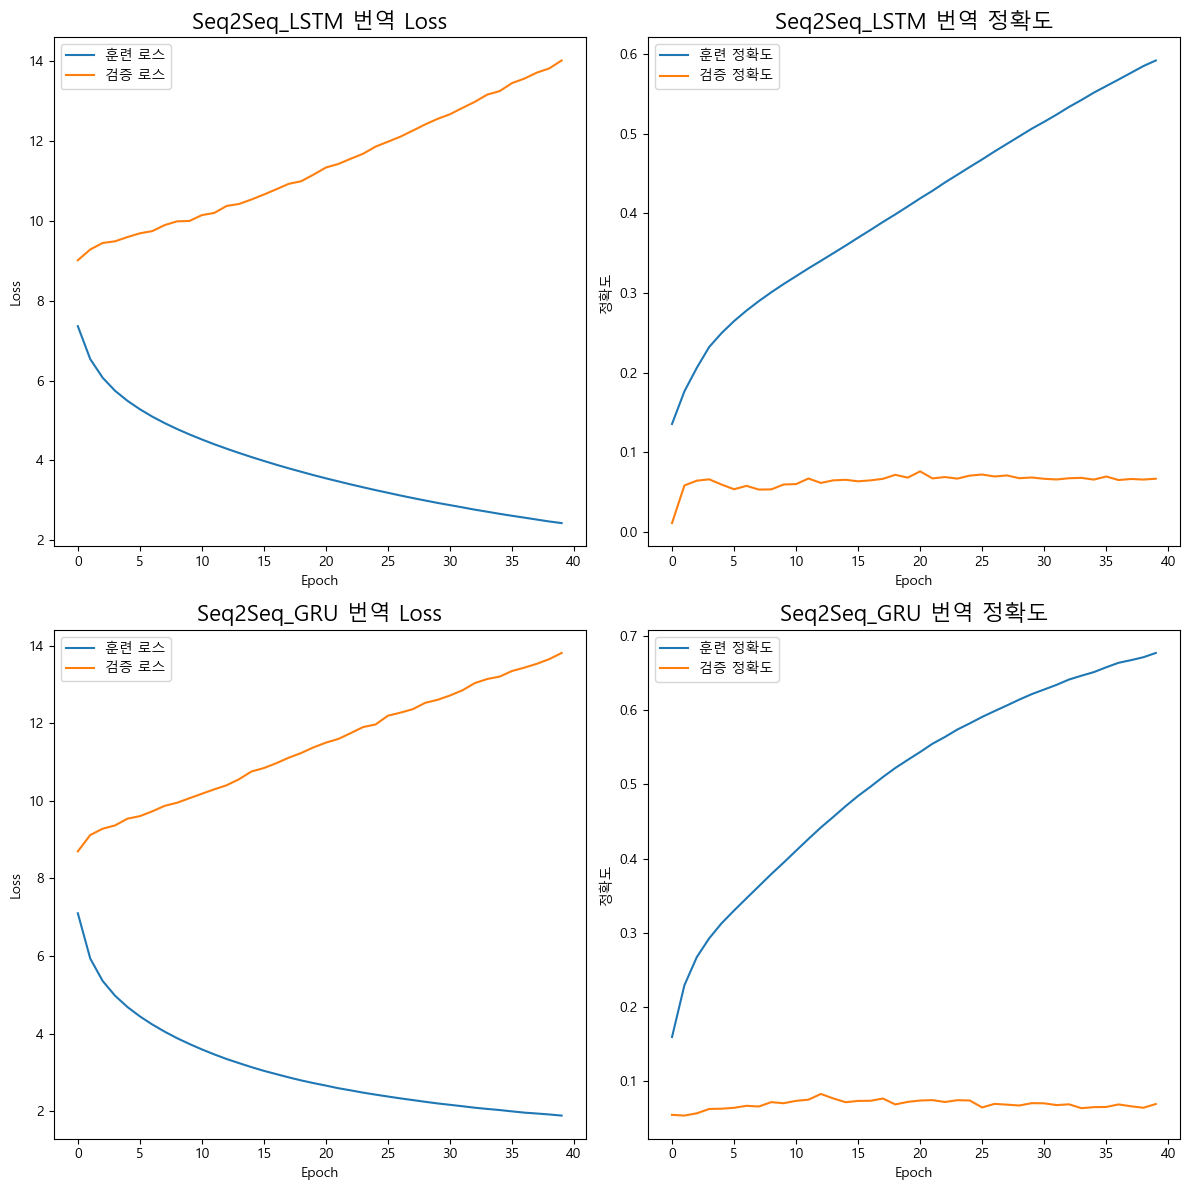

In [42]:
# 손실 및 정확도 그래프 그리기 그래프 생성
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()  # 2차원 배열을 1차원으로 변환하여 인덱싱 쉽게 함

# 손실 그래프 그리기
for idx, key in enumerate(model_key):
    ax = axes[idx*2] #손실 그래프는 0, 2번째에 위치
    ax.plot(res_data[key]['훈련_Loss'], label='훈련 로스')
    ax.plot(res_data[key]['검증_Loss'], label='검증 로스')

    ax.set_title(f'Seq2Seq_{key} 번역 Loss', fontsize=16)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

# 정확도 그래프 그리기
for idx, key in enumerate(model_key):
    ax = axes[idx*2 + 1] #정확도 그래프는 1, 3번째에 위치
    ax.plot(res_data[key]['훈련_정확도'], label='훈련 정확도')
    ax.plot(res_data[key]['검증_정확도'], label='검증 정확도')
    ax.set_title(f'Seq2Seq_{key} 번역 정확도', fontsize=16)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('정확도')
    ax.legend()


plt.tight_layout()
plt.show()

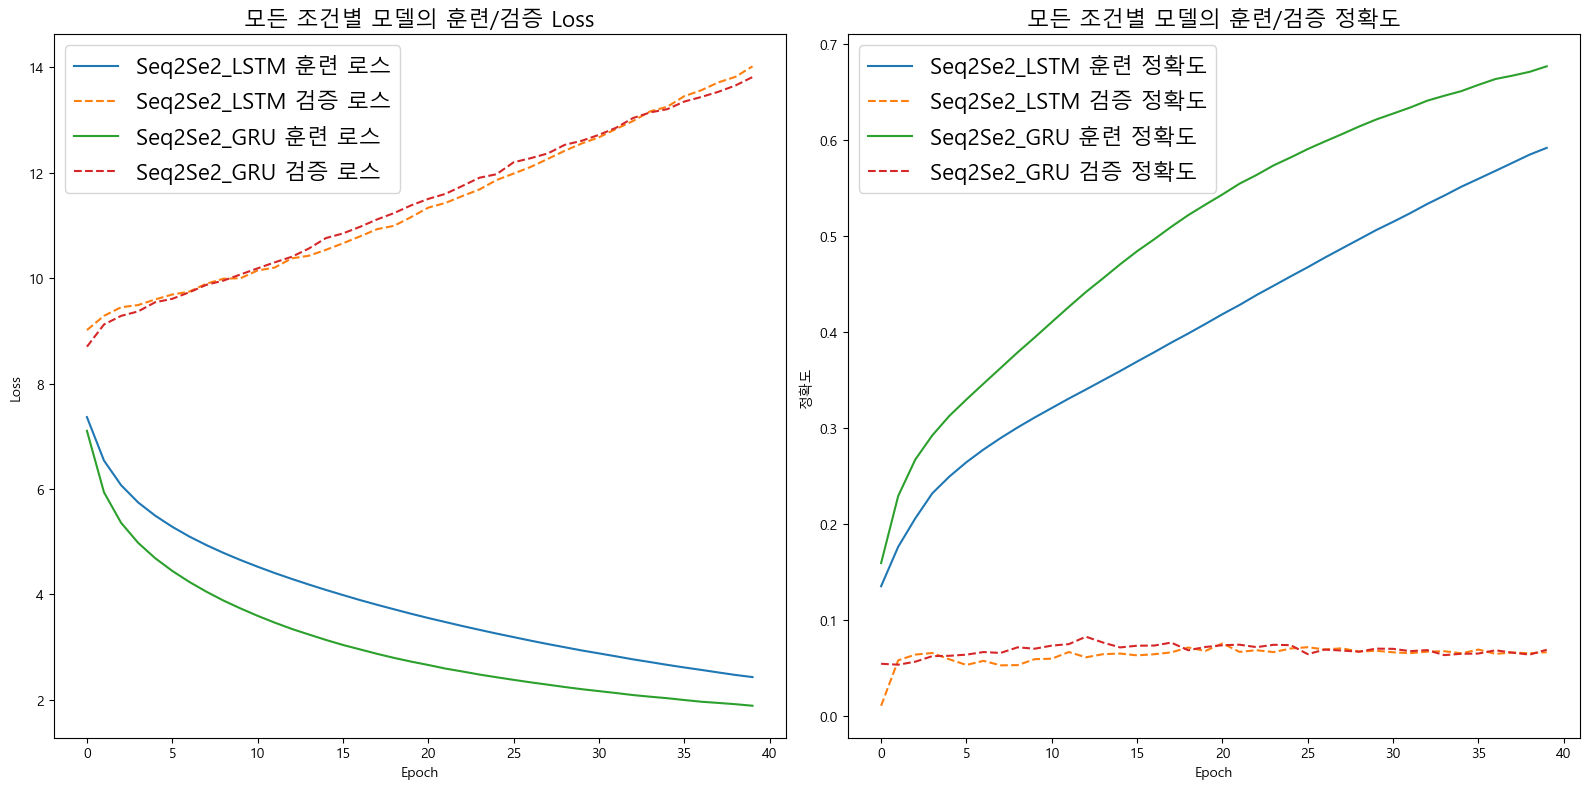

In [43]:
# 모든 모델의 손실과 정확도를 비교하는 그래프 생성
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 모든 모델의 손실 그래프
ax = axes[0]
for key in model_key:
    ax.plot(res_data[key]['훈련_Loss'], label=f'Seq2Se2_{key} 훈련 로스')
    ax.plot(res_data[key]['검증_Loss'], label=f'Seq2Se2_{key} 검증 로스', linestyle='--')
ax.set_title('모든 조건별 모델의 훈련/검증 Loss', fontsize=16)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(fontsize=16)  # 범례의 폰트 크기 설정

# 모든 모델의 정확도 그래프
ax = axes[1]
for key in model_key:
    ax.plot(res_data[key]['훈련_정확도'], label=f'Seq2Se2_{key} 훈련 정확도')
    ax.plot(res_data[key]['검증_정확도'], label=f'Seq2Se2_{key} 검증 정확도', linestyle='--')
ax.set_title('모든 조건별 모델의 훈련/검증 정확도', fontsize=16)
ax.set_xlabel('Epoch')
ax.set_ylabel('정확도')
ax.legend(fontsize=16)  # 범례의 폰트 크기 설정

plt.tight_layout()
plt.show()

In [44]:
# 학습된 모델 저장
path = {} #모델별 경로명 저장
for mk in model_key:
    path[mk] = f'Seq2Seq_{mk}.pth'
    # torch.save(models[mk].state_dict(), path[mk])

In [45]:
# 저장된 모델 불러오기
load_model = {
    'LSTM': Translater_lstm,  # LSTM 모델 인스턴스 생성
    'GRU': Translater_gru     # GRU 모델 인스턴스 생성
}
for mk in model_key:
    load_model[mk].load_state_dict(torch.load(path[mk], weights_only=True))
    #추론기는 CPU에서 돌리자
    load_model[mk] = load_model[mk].to('cpu')

In [46]:
import random
# 테스트 데이터셋에서 샘플을 추출
# 전체 테스트 데이터 개수정보를 추출
num_test = padded_src_test.shape[0]
sample_epoch = 10 #추출할 샘플 개수 정의
indices = random.sample(range(num_test), sample_epoch)

# 추출한 샘플번호를 바탕으로 Test 데이터셋에서 무작위 추출
S_src_test = padded_src_test[indices]
S_tar_test = padded_tar_test[indices]

# 원문 데이터만 텐서 자료형으로 변환
TS_src_test = torch.tensor(S_src_test, dtype=torch.long)

In [61]:
# 모델 추론용 함수
def model_inference(model, src_data):
    device = next(model.parameters()).device # 모델의 연산위치 확인
    model.eval() # 모델을 평가 모드로 설정

    with torch.no_grad(): #평가모드에서는 그래디언트 계산 중단
        src_data = src_data.to(device)
        # 추론에서 입력되는 데이터 구조는 (1, src_seq_len)이다.
        # 추론 과정이기에 정답지(tar_data)는 입력하지 않는다.
        # Beamsearch의 search_space(Beam_width)값 설정
        tar_infer = model(src_data)
        # 추론결과는 (BS=1, max_len, BW) -> numpy자료형 변환
        nd_tar_infer = tar_infer.cpu().numpy()

    if tar_infer.size(0) == 1: # BS가 1 인 경우
        return nd_tar_infer[0] #BS 차원을 날림
    else:
        return nd_tar_infer #(BS, max_len, BW)

In [62]:
# from Seq_trainer import *

# 추론 결과를 저장할 딕셔너리
tar_dict = {key: []  for key in model_key}

for key in model_key:
    print(f"\n--현재 추론 조건: [Seq2Seq_{key}]--") # 조건에 맞는 실험시작
    for idx in tqdm(range(sample_epoch)): #추론 에포크별 추론 시작
        # 입력되는 원문 차원을 (1, src_seq_len)으로 만들기 위한 코드
        iter_src_data = TS_src_test[idx].unsqueeze(0)
        # 모델 추론 -> 추론결과는 (bs, max_len) ndarray타입임
        tar_infer_doc = model_inference(load_model[key], iter_src_data)
        tar_dict[key].append(tar_infer_doc)


--현재 추론 조건: [Seq2Seq_LSTM]--


100%|██████████| 10/10 [00:00<00:00, 16.72it/s]



--현재 추론 조건: [Seq2Seq_GRU]--


100%|██████████| 10/10 [00:00<00:00, 16.94it/s]


In [63]:
idx_list = range(1, sample_epoch+1)
for idx, src, pred_lstm, pred_gru, tar in zip(idx_list, S_src_test, 
                                              tar_dict['LSTM'], 
                                              tar_dict['GRU'], 
                                              S_tar_test):
    # 원문, 모델번역문_1, 모델번역문_2, 정답번역문 순으로 디코딩
    decode_src = Translater_post_processor(src, idx_to_src, spec_token)
    de_pred_lstm = Translater_post_processor(pred_lstm, idx_to_tar, spec_token)
    de_pred_gru = Translater_post_processor(pred_gru, idx_to_tar, spec_token)
    decode_tar = Translater_post_processor(tar, idx_to_tar, spec_token)

    print(f"{idx}번째 번역 결과 확인")
    print(f"원문(src) : {decode_src}")
    print(f"seqLSTM번역 : {de_pred_lstm}")
    print(f"seq-GRU번역 : {de_pred_gru}")
    print(f"번역문(tar) : {decode_tar}")
    print("==============================\n")

1번째 번역 결과 확인
원문(src) : die suche nach dem verantwortlichen fur die seuche geht weiter .
seqLSTM번역 : 그 책임자들은 그 어느 때보다 더 깊이 빠져들게 됩니다 .
seq-GRU번역 : 미래를 위해 그는 무기를 되찾고 탈출을 보호합니다 .
번역문(tar) : 그 전염병에 책임이 있는 사람을 찾는 일은 계속되고 있습니다 .

2번째 번역 결과 확인
원문(src) : und dies ist einer von ihnen , sie stellen produkte zur verfugung , damit ich sie fur euch uberprufen kann .
seqLSTM번역 : 그리고 이것은 당신이 한국에서 가장 좋아하는 동영상 블로그 중 하나이기 때문에 그것을 가지고 있는지 확인하십시오 .
seq-GRU번역 : 그리고 그것을 사용할 수 있으니 추가 권장할 수 있으니 이것도 다릅니다 .
번역문(tar) : 그리고 이것은 그들 중 하나입니다 . 그들은 여러분을 위해 검토할 제품을 제공합니다 .

3번째 번역 결과 확인
원문(src) : sie sollten es also besser jetzt tun .
seqLSTM번역 : 이제 더 더 더 쉬워기만 하면 됩니다 .
seq-GRU번역 : 이제 할 수 있을 것 같아요 .
번역문(tar) : 그러니 지금 하는 것이 더 좋습니다 .

4번째 번역 결과 확인
원문(src) : mesut steht einen wettbewerb kurz vor dem ende seiner funfjahrigen ehe durch .
seqLSTM번역 : 그 사이에 할로윈은 이미 법정에서 멀어지게 합니다 .
seq-GRU번역 : 이 차에는 어렸을 때 아리엘보 킬로미터를 차워 .
번역문(tar) : 메수트가 그의의 결혼생활이 끝나기 직전에 대회를 통해 극복한다 .

5번째 번역 결과 확인
원문(src) : aber er kann seiner verwandtschaft n